# Scientific Presentation Script Generator with Local Galileo & ChromaDB

This notebook leverages a RAG (Retrieval-Augmented Generation) architecture to generate a scientific presentation script. The process begins by querying the arXiv API for papers related to a specific topic. After retrieving the relevant papers, the notebook applies preprocessing and formatting pipelines to generate a cohesive and informative script.

## Overview

- Imports  
- Configurations  
- Search and download scientific papers  
- Preprocessing (chunking and embedding)  
- Storage in vector database (ChromaDB)  
- Galileo setup and configuration  
- Model selection  
- Script generation  
- Model service deployment  


## Step 0: Configuring the environment
This step install the necessary libraries for connecting with Galileo and the models




In [1]:
!pip install -r ../requirements.txt --quiet

In [2]:
# System
import os
import sys
import yaml
import mlflow

# Add the src directory to the path to import utils
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))
from src.utils import configure_hf_cache
from src.utils import configure_proxy
from src.utils import load_config_and_secrets
from src.utils import initialize_llm


# Import transformers from huggingface
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

# Import galileo libraries
import promptquality as pq
from promptquality import NodeRow, NodeType

#Import components of notebook
from core.extract_text.arxiv_search import ArxivSearcher
from core.generator.script_generator import ScriptGenerator
from core.analyzer.scientific_paper_analyzer import ScientificPaperAnalyzer
from core.deploy.text_generation_service import TextGenerationService

#import langchain libraries
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.schema import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.prompts import ChatPromptTemplate
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema import StrOutputParser
from langchain_huggingface import HuggingFacePipeline, HuggingFaceEndpoint
from langchain_core.callbacks import CallbackManager, StreamingStdOutCallbackHandler
from langchain_community.llms import LlamaCpp

# Libraries from python
from typing import List

### Configuration and Secrets Loading


In [ ]:
CONFIG_PATH  = "../../configs/config.yaml"
SECRETS_PATH = "../../configs/secrets.yaml"
LOCAL_MODEL_PATH = "/home/jovyan/datafabric/llama2-7b/ggml-model-f16-Q5_K_M.gguf"
MLFLOW_EXPERIMENT_NAME  = "Text-Generation-service"
MLFLOW_RUN_NAME = "Script-Generation"
MLFLOW_MODEL_NAME = "Script-Generation-Service"


In [4]:
config, secrets = load_config_and_secrets(CONFIG_PATH, SECRETS_PATH)

### Proxy Configuration

In order to connect to Galileo service, a SSH connection needs to be established. For certain enterprise networks, this might require an explicit setup of the proxy configuration. If this is your case, set up the "proxy" field on your config.yaml and the following cell will configure the necessary environment variable.

In [5]:
configure_proxy(config)

### Configuration of Hugging face caches

In the next cell, we configure HuggingFace cache, so that all the models downloaded from them are persisted locally, even after the workspace is closed. This is a future desired feature for AI Studio and the GenAI addon.

In [6]:
# Configure HuggingFace cache
configure_hf_cache()

In [7]:
# Initialize HuggingFace Embeddings
embeddings = HuggingFaceEmbeddings()

2025-05-21 10:31:06,457 | INFO | PyTorch version 2.6.0 available.
2025-05-21 10:31:06,725 | INFO | Use pytorch device_name: cuda
2025-05-21 10:31:06,725 | INFO | Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
/opt/conda/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## 📚 Chapter 1: Building the Paper Research and Processing Pipeline
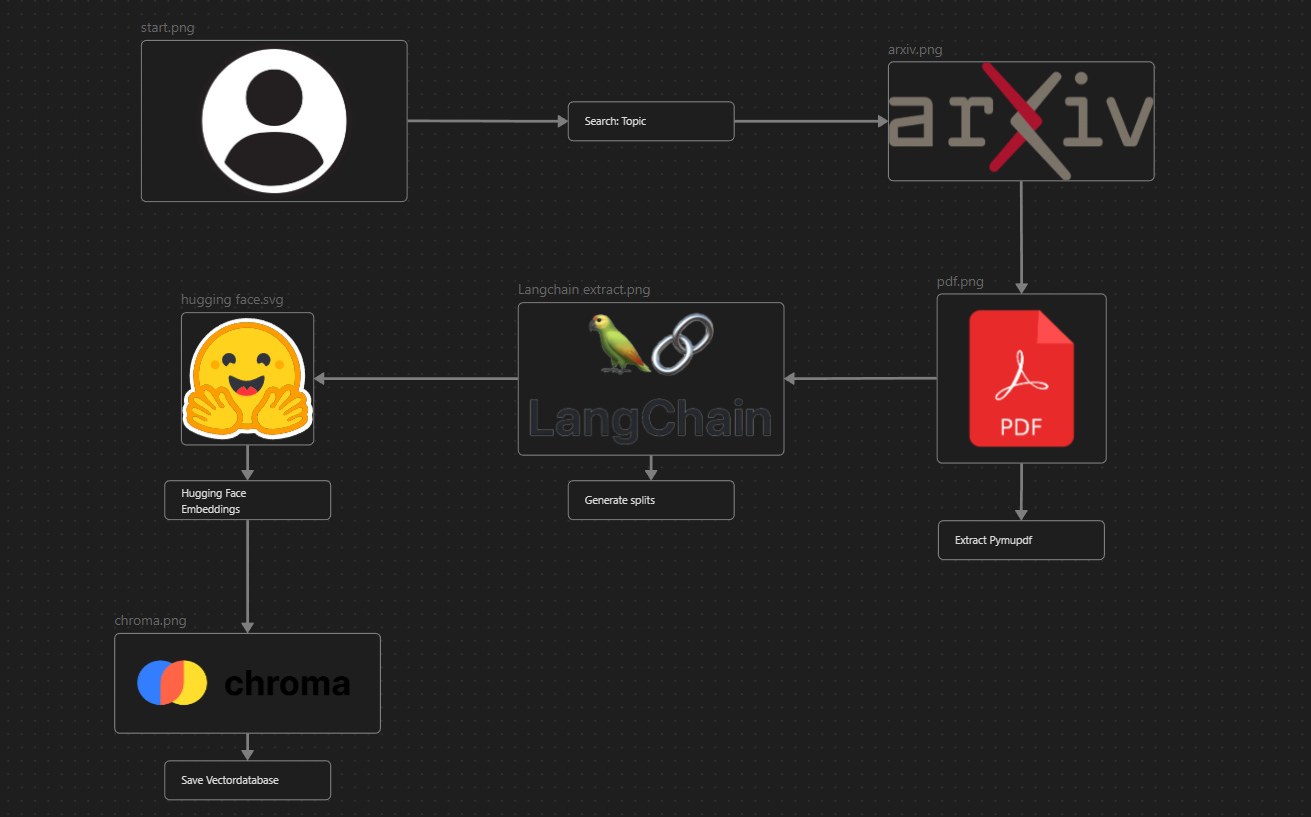
In this chapter, we construct a complete pipeline to search, process, and prepare scientific papers for downstream generation tasks. The workflow is broken down into the following stages:

🔍 **Paper Research**
The process begins by selecting a specific topic and retrieving relevant scientific papers via APIs such as arXiv.

⬇️ **Paper Download**
Once the desired paper is identified, its PDF is downloaded and saved locally for further processing.

🧾 **Text Extraction**
The content of the PDF is extracted using the PyMuPDF library, resulting in a raw text version of the scientific paper.

✂️ **Chunk Creation**
The extracted text is segmented into smaller, manageable units ("chunks") using LangChain's RecursiveCharacterTextSplitter. This enables better contextual handling.

🧠 **Embedding Generation**
Each chunk is transformed into a vector representation (embedding) using HuggingFaceEmbeddings, enabling semantic understanding and searchability.

🧩 **Storage in Vector Database**
The embeddings are then stored in a local vector database powered by ChromaDB, making it possible to perform similarity searches based on content.

> 🚀 This pipeline sets the foundation for a robust RAG (Retrieval-Augmented Generation) system tailored for scientific presentations.

### 🔎 Step 1: Searching Scientific Papers
In this step, we use the arXiv API to find and extract relevant scientific papers based on a topic provided by the user. The process prepares the raw text content that will later be used for generation.

The flow is composed of the following steps:

1. **📝 Define the Query**
The user inputs a keyword or topic of interest. An optional max_results parameter can be configured (default is 1).

2. **🌐 Search on arXiv**
The function search_arxiv_and_extract_text sends a request to the arXiv API using the provided query. The response includes metadata about matching papers.

3. **📄 Parse the Response**
The XML returned by the API is parsed to extract key information such as the paper title and the PDF download link.

4. **⬇️ Download the PDF**
The paper is downloaded locally using the download_pdf function and saved to a temporary directory.

5. **🧾 Extract Raw Text**
The downloaded PDF is parsed using the PyMuPDF library. The extracted text is consolidated and returned as a plain string, which serves as input for the next stages (embedding and generation).

📁 The paper retrieval logic is implemented in `src/extract_text/arxiv_search.py`

In [8]:
searcher = ArxivSearcher(query="large language models", max_results=2, logging_enabled=True)
papers = searcher.search_and_extract()

2025-05-21 10:31:13,649 | INFO | Extracted text from 'Lost in Translation: Large Language Models in Non-English Content
  Analysis':
Lost in Translation
May 2023
A report from
Gabriel Nicholas
Aliya Bhatia
Large Language Models in 
Non-English Content Analysis

GABRIEL NICHOLAS
Research Fellow at the Center for Democracy & Technology.
ALIYA BHATIA
Policy Analyst, Free Expression Project at the Center for 
Democracy & Technology.
...

2025-05-21 10:31:14,567 | INFO | Extracted text from 'Cedille: A large autoregressive French language model':
CEDILLE:
A LARGE AUTOREGRESSIVE LANGUAGE MODEL IN FRENCH
Martin Müller∗
Florian Laurent∗
Cedille AI1
hello@cedille.ai
ABSTRACT
Scaling up the size and training of autoregressive language models has enabled novel ways of solving
Natural Language Processing tasks using zero-shot and few-shot learning....



In [9]:
papers

[{'title': 'Lost in Translation: Large Language Models in Non-English Content\n  Analysis',
  'text': 'Lost in Translation\nMay 2023\nA report from\nGabriel Nicholas\nAliya Bhatia\nLarge Language Models in \nNon-English Content Analysis\n\nGABRIEL NICHOLAS\nResearch Fellow at the Center for Democracy & Technology.\nALIYA BHATIA\nPolicy Analyst, Free Expression Project at the Center for \nDemocracy & Technology.\nThe Center for Democracy & Technology (CDT) is the leading \nnonpartisan, nonprofit organization fighting to advance civil rights and \ncivil liberties in the digital age. We shape technology policy, governance, \nand design with a focus on equity and democratic values. Established in \n1996, CDT has been a trusted advocate for digital rights since the earliest \ndays of the internet. The organization is headquartered in Washington, \nD.C., and has a Europe Office in Brussels, Belgium.\n\nA report from\nGabriel Nicholas and Aliya Bhatia\nWITH CONTRIBUTIONS BY\nSamir Jain, Mallo

### 🧱 Step 2: Processing and Embedding Generation
In this step, we transform the raw text extracted from the papers into structured embeddings that can be stored and retrieved efficiently in the RAG pipeline.

The flow includes three main stages:

1. **📄 Create Document Objects**
The full text of each paper is wrapped into Document objects — a standard structure used by LangChain to manage and manipulate textual data.

2. **✂️ Split Text into Chunks**
Using LangChain's RecursiveCharacterTextSplitter, the documents are segmented into smaller blocks (chunks) based on character limits. This makes the downstream embedding and retrieval process more effective.

The chunk_size parameter defines the maximum length of each chunk.

3. **📊 Generate Embeddings**
Each text chunk is converted into a vector representation (embedding) using HuggingFaceEmbeddings. These embeddings are later used to populate the vector store and serve as the foundation for similarity-based retrieval in the generation step.



In [10]:
# Creates a list of Document objects from the scientific articles in the `papers` variable.
# Each `Document` is created with the article content and a metadata dictionary containing the title.
documents = [Document(page_content=paper['text'], metadata={"title": paper['title']}) for paper in papers]

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1200, chunk_overlap=400)
splits = text_splitter.split_documents(documents)

### 🧩 Step 3: Vector Data Storage and Retrieval
This step handles the storage of embeddings into a vector database and configures a retriever to enable similarity-based search — a key component in the RAG pipeline.

🧠 Store Embeddings with Chroma
The segmented text chunks, previously converted into embeddings, are stored in a local vector store using ChromaDB. This enables efficient access to semantically similar information later on.

🔎 Configure the Retriever
After storing the embeddings, a retriever is set up to perform similarity search queries. This retriever is responsible for:

- Receiving a user query or prompt

- Searching through the stored embeddings

- Returning the most relevant chunks based on vector similarity

> 📦 This mechanism allows the generation model to work with only the most relevant information, improving accuracy and reducing hallucinations.

In [11]:
#Our vector database
vectordb = Chroma.from_documents(documents=splits, embedding=embeddings)

2025-05-21 10:31:14,786 | INFO | Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


In [12]:
retriever = vectordb.as_retriever()

## 🧠 Chapter 2: Building a Prompt Flow for Generating Scientific Presentation Scripts
In this chapter, we build a prompt flow to generate a complete scientific presentation script using LLMs. Each section of the script (e.g., title, introduction, methodology) is created individually through dedicated prompt templates.

The process is composed of four main steps:

1. ✅ **Login via Galileo**
Authenticate to enable logging of prompt quality and results for later evaluation.

2. 🧠 **Model Selection**
Choose the best-suited LLM for the generation task, depending on performance or local availability.

3. 🔍 **Analysis with ScientificPaperAnalyzer**
Using the component ScientificPaperAnalyzer, a custom LangChain chain is built to analyze the scientific paper and generate context-aware responses.

4. 🧾 **Script Generation with Logging**
The ScriptGenerator orchestrates the prompt flow, allowing users to generate each section of the presentation interactively, while logging all interactions to Galileo for tracking and evaluation.



#### ⚙️ Step 4: Config Enviroment


In [13]:

#########################################
# In order to connect to Galileo, create a secrets.yaml file in the same folder as this notebook
# This file should be an entry called Galileo, with the your personal Galileo API Key
# Galileo API keys can be created on https://console.hp.galileocloud.io/settings/api-keys
#########################################

os.environ['GALILEO_API_KEY'] = secrets["GALILEO_API_KEY"]
os.environ['GALILEO_CONSOLE_URL'] = "https://console.hp.galileocloud.io/" 
GALILEO_PROJECT_NAME = 'Academic Script'
pq.login(os.environ['GALILEO_CONSOLE_URL'])

👋 You have logged into 🔭 Galileo (https://console.hp.galileocloud.io/) as diogo.vieira@hp.com.


Config(console_url=HttpUrl('https://console.hp.galileocloud.io/'), username=None, password=None, api_key=SecretStr('**********'), token=SecretStr('**********'), current_user='diogo.vieira@hp.com', current_project_id=None, current_project_name=None, current_run_id=None, current_run_name=None, current_run_url=None, current_run_task_type=None, current_template_id=None, current_template_name=None, current_template_version_id=None, current_template_version=None, current_template=None, current_dataset_id=None, current_job_id=None, current_prompt_optimization_job_id=None, api_url=HttpUrl('https://api.hp.galileocloud.io/'))

### 🧠 Model config

In this notebook, we provide three different options for loading the model:

- **local**: by loading the llama2-7b model from the asset downloaded on the project
- **hugging-face-local** by downloading a DeepSeek model from Hugging Face and running locally
- **hugging-face-cloud** by accessing the Mistral model through Hugging Face cloud API (requires HuggingFace API key saved on secrets.yaml)
  
This choice can be set in the variable model_source below or as an entry in the config.yaml file. The model deployed on the bottom cells of this notebook will load the choice from the config file.

In [14]:
model_source = ""
if "model_source" in config:
    model_source = config["model_source"]

llm = initialize_llm(model_source, secrets)

/tmp/ipykernel_6483/3663350891.py:5: DeprecationWarning: callback_manager is deprecated. Please use callbacks instead.
  llm = initialize_llm(model_source, secrets)


In [15]:
analyzer = ScientificPaperAnalyzer(retriever=retriever, llm=llm, logging_enabled=True)
response = analyzer.analyze("What are the main findings of the paper?")
print(response)


2025-05-21 10:31:57,428 | INFO | Building the LangChain chain...
2025-05-21 10:31:57,429 | INFO | Analyzing prompt: 'What are the main findings of the paper?'
/home/jovyan/aistudio-galileo-templates-feat-UI-for-text-generation/03-text-generation-with-langchain/notebooks/core/analyzer/scientific_paper_analyzer.py:51: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = self.retriever.get_relevant_documents(query)
2025-05-21 10:31:57,853 | INFO | Retrieved 4 documents for query: 'What are the main findings of the paper?'
2025-05-21 10:31:57,853 | INFO | Formatted 4 documents into context.
2025-05-21 10:31:57,854 | INFO | Context preview: OHCHR. [perma.cc/Y6MK-SZZ4]
Vallee, H. Q. la, & Duarte, N. (2019). Algorithmic Systems in Education: Incorporating Equity and Fairness When 
Using Student Data. Center for Democracy and Technology. [perma.cc/CC89-ZVNV]
Vaswa

Research questions:
- Does large language model (LLM) performance differ in content analysis tasks for non-English language texts compared to English text? 
- Does the choice of task matter, e.g., translation vs. NLU?

Expected outcome:
- Describe main findings and suggest possible reasons.
- Present results of our own experiments in the paper's text.

Data:
- 'French Wikipedia,' as used in the paper
- A set of French Wikipedia articles

Methodology:
- Evaluate a large number of LLMs on four content analysis tasks - translation, NLU, article summarization (AS) and NLU/article summarization (NLS), with their own baselines and results.
- Analyze the F1 scores for these tasks for French Wikipedia articles from various sources, including the OpenAI's "GPT-3" language models, GPT2, BART, and ALBERT.

Results:
- In general, LLMs performed well in translation (F1: 57.0%) but not on NLU tasks. The best-performing model on the AS task was TuringBot (F1: 94.8%).
- GPT-3's performance is stronges

### ✅ Step 6: Run and Approve
The ScriptGenerator component is responsible for generating each section of the scientific presentation script in an interactive and human-in-the-loop fashion.

In [16]:
generator = ScriptGenerator(chain=analyzer.get_chain(), logging_enabled=True)

# Title
generator.add_section(
    name="title",
    prompt="Generate a clear and concise title for the presentation that reflects the content. Add a subtitle if needed. Respond using natural language only."
)

# Introduction
generator.add_section(
    name="introduction",
    prompt="""Write the introduction of the presentation including:
- Contextualization of the general theme.
- Relevance of the topic, both academically and practically.
- A brief literature review.
- A clear definition of the research problem.
- The specific objectives of the research.
- Hypotheses (if applicable).
Respond using only natural language, no structured format or dictionaries."""
)

# Methodology
generator.add_section(
    name="methodology",
    prompt="""Write the methodology section including:
- Research Design (e.g., experimental, descriptive, exploratory).
- Sample and Population details.
- Data Collection methods.
- Instruments used.
- Data Analysis techniques.
Answer clearly in plain text using natural language only."""
)

# Results
generator.add_section(
    name="results",
    prompt="""Write the results section including:
- Presentation of data (feel free to mention tables or graphs).
- Initial interpretation of the data.
- Comparison with hypotheses (if applicable).
Answer using natural language only. Avoid structured outputs."""
)

# Conclusion
generator.add_section(
    name="conclusion",
    prompt="""Write the conclusion of the study including:
- A synthesis of the main results.
- Response to the research problem.
- The study's academic or practical contributions.
- Final reflections or recommendations.
Respond in full natural text without any structured formatting."""
)

# References
generator.add_section(
    name="references",
    prompt="""List the references for the study:
- Include all sources cited in the presentation.
- Format them according to a recognized citation style (APA, MLA, Chicago, etc.).
Answer in natural language with correct formatting."""
)

# Run and combine
generator.run()

script = generator.get_final_script()
print("Final Script:\n", script)


2025-05-21 10:32:19,621 | INFO | Section 'title' added.
2025-05-21 10:32:19,622 | INFO | Section 'introduction' added.
2025-05-21 10:32:19,622 | INFO | Section 'methodology' added.
2025-05-21 10:32:19,623 | INFO | Section 'results' added.
2025-05-21 10:32:19,623 | INFO | Section 'conclusion' added.
2025-05-21 10:32:19,623 | INFO | Section 'references' added.
2025-05-21 10:32:19,624 | INFO | Running section 'title'.
2025-05-21 10:32:21,714 | INFO | Generating section 'title'…
2025-05-21 10:32:21,804 | INFO | Retrieved 4 documents for query: 'Generate a clear and concise title for the presentation that reflects the content. Add a subtitle if needed. Respond using natural language only.'
2025-05-21 10:32:21,805 | INFO | Formatted 4 documents into context.
2025-05-21 10:32:21,806 | INFO | Context preview: on statistical machine translation”. In: Proceedings
of the ninth workshop on statistical machine trans-
lation. 2014, pp. 12–58.
[34]
Kishore Papineni et al. “Bleu: a method for auto-
ma


>>> [title] Result:
Title: Large Languaage Modeling of Non-English Content Analysis

Abstract: The goal of this presentation is to introduce the research topic of large language model (LLM) in the context of  non-English content analysis. We will present examples of how LLMs can be used for tasks such as machine translation, image captioning and text summarization. In particular, we will discuss how LLMs are currently being used to analyze large amounts of untranslated text from social media platforms or other websites in order to detect hate speech, misinformation, or discriminatory content. The presentation will also touch on the challenges associated with training such models and exploring their potential benefits for social justice and human rights advocacy.

Introduction:

Given the rise of digital technologies that have disrupted traditional modes 
of communication and distribution of information, research in natural 
language processing (NLP) has emerged as an important area of

Approve the result? (y/n):  y


Initial job complete, executing scorers asynchronously. Current status:


2025-05-21 10:33:27,167 | INFO | Running section 'introduction'.


cost: Done ✅
toxicity: Done ✅
pii: Done ✅
protect_status: Done ✅
prompt_perplexity: Done ✅
latency: Done ✅
groundedness: Computing 🚧
factuality: Computing 🚧
🔭 View your prompt run on the Galileo console at: https://console.hp.galileocloud.io/prompt/chains/77bac02d-5af1-4119-9ef6-0a58f53ba098/08958ae0-5668-4078-8c45-e8509b6f0c2b?taskType=12


2025-05-21 10:33:28,884 | INFO | Generating section 'introduction'…
2025-05-21 10:33:29,077 | INFO | Retrieved 4 documents for query: 'Write the introduction of the presentation including:
- Contextualization of the general theme.
- Relevance of the topic, both academically and practically.
- A brief literature review.
- A clear definition of the research problem.
- The specific objectives of the research.
- Hypotheses (if applicable).
Respond using only natural language, no structured format or dictionaries.'
2025-05-21 10:33:29,078 | INFO | Formatted 4 documents into context.
2025-05-21 10:33:29,078 | INFO | Context preview: — development, testing, deployment, and evaluation (Prabhakaran et al., 2022). 
Publishing human rights impact assessments will also aid in other actors’ decisions 
when procuring these systems to conduct tasks in different domains and contexts. In 
particular, these human rights impact assessments ...
2025-05-21 10:34:03,790 | INFO | Model output (introduction):


>>> [introduction] Result:
The present is focused on the effect of large language models (LLMs) on translation 
quality and efficiency, while considering potential human rights risk. The 
conducted research was to evaluate LLMs for their accuracy in translating a diverse set 
of context-sensitive sentences from one language to another, and identify the 
risk of disparities to different languages’ speaker groups. Specifically, this 
research aimed to:

1) Investigate how LLMs perform when trained on multiple datasets, with varying 
references and source texts, and with different target langauges.

2) Analyze the disparities between LLM performance on target and reference languagues 
underlying LLM’s translation quality in terms of context sensitivity and speaker 
groups.

3) Determine how the translator(s) involved in this process, whether manually or by 
machine, impacted the translation quality, accuracy, and efficiency.

4) Discuss potential human rights risk in the use of LLMs for 

Approve the result? (y/n):  y


Initial job complete, executing scorers asynchronously. Current status:


2025-05-21 10:34:46,338 | INFO | Running section 'methodology'.


cost: Done ✅
toxicity: Done ✅
pii: Done ✅
protect_status: Done ✅
prompt_perplexity: Done ✅
latency: Done ✅
groundedness: Computing 🚧
factuality: Computing 🚧
🔭 View your prompt run on the Galileo console at: https://console.hp.galileocloud.io/prompt/chains/e62efb8e-aa29-48bd-bf81-bce7bdda32a8/ded4a6a0-9025-42a3-9857-c62415796cf5?taskType=12


2025-05-21 10:34:48,420 | INFO | Generating section 'methodology'…
2025-05-21 10:34:48,564 | INFO | Retrieved 4 documents for query: 'Write the methodology section including:
- Research Design (e.g., experimental, descriptive, exploratory).
- Sample and Population details.
- Data Collection methods.
- Instruments used.
- Data Analysis techniques.
Answer clearly in plain text using natural language only.'
2025-05-21 10:34:48,564 | INFO | Formatted 4 documents into context.
2025-05-21 10:34:48,565 | INFO | Context preview: Suggested Citation: Nicholas, G. and Bhatia, A. (2023) Lost in Translation: Large Language Models 
in Non-English Content Analysis. Center for Democracy & Technology. https://cdt.org/insights/lost-
in-translation-large-language-models-in-non-english-content-analysis/
References in this report includ...
2025-05-21 10:35:23,633 | INFO | Model output (methodology): Lost in Translation CDT Research 52 Introduction 49 ​The importance of language models and NLP for content a


>>> [methodology] Result:
Lost in Translation
CDT Research
52
Introduction
49
​The importance of language models and NLP for content analysis 
increasingly becomes a critical factor, particularly as the world is increasingly becoming more globalized, with new languages being added to the list every year. With the help of the internet, digital content becomes globally available at low costs, creating huge opportunities for businesses, institutions and governments. However, it also presents some challenges that researchers need to grapple with in order to ensure public accountability from content analysis conducted using multi-lingual language models. 
1) Introduction
NLP is the process of converting natural human language into digital form. NLP has gained tremendous traction in recent times, and it is being used across various industries. Apart from chatbots, NLP has also been employed in content analysis. NLP helps to identify relevant information from a large body of data. Language m

Approve the result? (y/n):  y


Initial job complete, executing scorers asynchronously. Current status:


2025-05-21 10:35:44,131 | INFO | Running section 'results'.


cost: Done ✅
toxicity: Done ✅
pii: Done ✅
protect_status: Done ✅
prompt_perplexity: Done ✅
latency: Done ✅
groundedness: Computing 🚧
factuality: Computing 🚧
🔭 View your prompt run on the Galileo console at: https://console.hp.galileocloud.io/prompt/chains/3b6e3fda-d3a9-4776-ae6c-20f464729dd0/bcd6b074-a2a6-49b3-882a-56a9ae7497bd?taskType=12


2025-05-21 10:35:45,868 | INFO | Generating section 'results'…
2025-05-21 10:35:46,035 | INFO | Retrieved 4 documents for query: 'Write the results section including:
- Presentation of data (feel free to mention tables or graphs).
- Initial interpretation of the data.
- Comparison with hypotheses (if applicable).
Answer using natural language only. Avoid structured outputs.'
2025-05-21 10:35:46,035 | INFO | Formatted 4 documents into context.
2025-05-21 10:35:46,036 | INFO | Context preview: high-quality French Wikipedia articles.
Model
F1
Exact match (%)
GPT-3 (ada)
19.09
4.48
GPT-3 (babbage)
26.16
8.81
GPT-3 (curie)
39.49
17.84
GPT-3 (davinci)
-
-
GPT-J
26.14
6.96
Cedille
34.59
12.23
Pagnol (small)
10.66
0.43
Pagnol (medium)
13.80
0.84
Pagnol (large)
17.67
2.72
GPT-fr (base)
15.15
2.0...
2025-05-21 10:36:11,466 | INFO | Model output (results): Data: The main dataset used in this paper is a set of 23 articles (5 original, 10 modified) from the French science fiction magazine “FQuAD”. 


>>> [results] Result:
Data: The main dataset used in this paper is a set of 23 articles (5 original, 10 modified) from the French science fiction magazine “FQuAD”. They cover a broad range of topics and can be found online at http://quad.ai/en/articles.

Initial Interpretation: The analysis presented in this paper aims to study the impact of different sentence-level preprocessing techniques on text summarization in french. The results show that using top-k greedy sampling and a temperature of 1 yields competitive performance for most models, with GPTAur being the best model (ROUGH score 7.24/30). However, some variance is observed due to the non-greedy sampling procedure used in the models evaluated, resulting in different output lengths.

Comparison with Hypotheses: The results of this analysis suggest that sentence-level preprocessing can impact the performance of text summarization models in french. The best performing model (GPTAur) seems to perform better than competitors when gr

Approve the result? (y/n):  y


Initial job complete, executing scorers asynchronously. Current status:


2025-05-21 10:36:43,003 | INFO | Running section 'conclusion'.


cost: Done ✅
toxicity: Done ✅
pii: Done ✅
protect_status: Done ✅
prompt_perplexity: Done ✅
latency: Done ✅
groundedness: Computing 🚧
factuality: Computing 🚧
🔭 View your prompt run on the Galileo console at: https://console.hp.galileocloud.io/prompt/chains/b97c737c-b7c0-4102-bf13-9c30c0c2b783/3dac967b-2f61-4bfa-8e31-5076efb35c86?taskType=12


2025-05-21 10:36:44,739 | INFO | Generating section 'conclusion'…
2025-05-21 10:36:44,873 | INFO | Retrieved 4 documents for query: 'Write the conclusion of the study including:
- A synthesis of the main results.
- Response to the research problem.
- The study's academic or practical contributions.
- Final reflections or recommendations.
Respond in full natural text without any structured formatting.'
2025-05-21 10:36:44,873 | INFO | Formatted 4 documents into context.
2025-05-21 10:36:44,874 | INFO | Context preview: A report from
Gabriel Nicholas and Aliya Bhatia
WITH CONTRIBUTIONS BY
Samir Jain, Mallory Knodel, Emma Llansó, Michal Luria, Nathalie Maréchal, Dhanaraj Thakur, and 
Caitlin Vogus.
ACKNOWLEDGMENTS 
We thank Pratik Joshi, Sebastin Santy, and Aniket Kesari for their invaluable feedback on the technica...
2025-05-21 10:36:51,934 | INFO | Model output (conclusion): Sujgested citations for this report include original links and links archived and shortened by the Perma.cc serv


>>> [conclusion] Result:
Sujgested citations for this report include original links and links archived and shortened by the Perma.cc service.



Approve the result? (y/n):  y


Initial job complete, executing scorers asynchronously. Current status:


2025-05-21 10:37:17,627 | INFO | Running section 'references'.


cost: Done ✅
toxicity: Done ✅
pii: Done ✅
protect_status: Done ✅
prompt_perplexity: Done ✅
latency: Done ✅
groundedness: Computing 🚧
factuality: Done ✅
🔭 View your prompt run on the Galileo console at: https://console.hp.galileocloud.io/prompt/chains/33049b57-e344-4d27-a7af-c95769444fa0/24edf442-d9ff-4816-b551-908ab4c8eaaf?taskType=12


2025-05-21 10:37:19,370 | INFO | Generating section 'references'…
2025-05-21 10:37:19,511 | INFO | Retrieved 4 documents for query: 'List the references for the study:
- Include all sources cited in the presentation.
- Format them according to a recognized citation style (APA, MLA, Chicago, etc.).
Answer in natural language with correct formatting.'
2025-05-21 10:37:19,512 | INFO | Formatted 4 documents into context.
2025-05-21 10:37:19,512 | INFO | Context preview: Lost in Translation
CDT Research
34
benchmarks lead to more publications, conferences, and real-world use cases. And 
finally, increased demand for research and software in a language drives demand for 
more datasets. For low resource languages, however, the virtuous cycle is hard to 
kickstart. Wit...
2025-05-21 10:37:27,240 | INFO | Model output (references): Incldue all sources citied in the presentation. Format them according to a recognized citatio style (APA, MLA, Chicago, etc.) Answer in natural languae with correct 


>>> [references] Result:
Incldue all sources citied in the presentation.
Format them according to a recognized citatio style (APA, MLA, Chicago, etc.)
Answer in natural languae with correct formatting.



Approve the result? (y/n):  y


Initial job complete, executing scorers asynchronously. Current status:
cost: Done ✅
toxicity: Done ✅
pii: Done ✅
protect_status: Done ✅
prompt_perplexity: Done ✅
latency: Done ✅
groundedness: Computing 🚧
factuality: Computing 🚧
🔭 View your prompt run on the Galileo console at: https://console.hp.galileocloud.io/prompt/chains/dd12abc7-ecda-4f20-b48a-1b266e8f5adb/f5aeda69-344e-4565-8ca0-94cd6ee91ef8?taskType=12
Final Script:
 Title: Large Languaage Modeling of Non-English Content Analysis

Abstract: The goal of this presentation is to introduce the research topic of large language model (LLM) in the context of  non-English content analysis. We will present examples of how LLMs can be used for tasks such as machine translation, image captioning and text summarization. In particular, we will discuss how LLMs are currently being used to analyze large amounts of untranslated text from social media platforms or other websites in order to detect hate speech, misinformation, or discriminatory 

## Model Service

In this section, we implement the **Model Service**, a REST API responsible for serving the language model. The API is automatically documented using Swagger (via FastAPI), enabling interactive testing and clear documentation of the endpoints.


In [17]:
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)

with mlflow.start_run(run_name=MLFLOW_RUN_NAME) as run:
    TextGenerationService.log_model(
        llm_artifact = LOCAL_MODEL_PATH,
        config_yaml  = CONFIG_PATH,
        secrets_yaml = SECRETS_PATH,
    )

    model_uri   = f"runs:/{run.info.run_id}/script_generation_model"
    model_info  = mlflow.register_model(model_uri, MLFLOW_MODEL_NAME)
    print(f"✔️ Model register: {model_info.name}, version: {model_info.version}")
 

✔️ Model register: Script-Generation-Service, version: 5


Registered model 'Script-Generation-Service' already exists. Creating a new version of this model...
Created version '5' of model 'Script-Generation-Service'.


Built with ❤️ using Z by HP AI Studio.